In [ ]:
import sys, os
from pathlib import Path
import random
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
from textwrap import fill

import utils.plot_utils as pu
from src.models import CensoredRW, train
from src.analysis import draw_G, test_multi, compare_mats, compare_pvr
from src.invite import sample_censored

from src.tools import cosine_model, markov_model, 
from src.tools import minmax, symmetrize, fill_diagonal, labeled_adj

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [104]:
sys.path.insert(0, os.path.abspath('..'))

pu.figure_setup()

net_path = Path('..')/'data'/'network_models_shared'
latex_path = Path('..')/'jmd19-latex'/'img'/'walshetal'
latex_path.mkdir(parents=True, exist_ok=True)




In [258]:
def get_struct(model):
    struct = pd.read_excel(net_path/f'{model}_component_model.xlsx', index_col=0)
    if model=='aircraft':
        edgel = struct.stack().reset_index()
        edgel = edgel[edgel[0]!=0]
        edgel['level_0'] = (
            edgel.level_0
            .str.split(' ')
            .str[:-1]
            .str.join(' ')
        )
        edgel['level_1'] = (
            edgel.level_1
            .str.split(' ')
            .str[:-1]
            .str.join(' ')
        )
        struct = (
            edgel
            .groupby(['level_0', 'level_1'])
            .sum().unstack()[0]
            .fillna(0)
        )
        struct[struct>1.]=1
    return struct

def plot_ivt(G, pos, MWOs, title, txtpos=.5, colwidth=60):

    palette = sns.color_palette("muted", n_colors=len(MWOs)).as_hex()

    plt.figure(figsize=pu.figsize(columns=2))

    mwotxts =[ f'#{n+1} ' + fill(
        f"{[G.node[i]['item'] for i in a]}", 
        width=60, subsequent_indent='      ' 
    ) for n, a in enumerate(MWOs)]

    plt.text(txtpos,.75, 'Tagged MWOs',
             fontsize=pu.font_size())

    for n, a in enumerate(MWOs):
        edgelist = [(a[n],a[n+1]) for n in range(len(a)-1)]
        jump_edges = nx.draw_networkx_edges(
            nx.DiGraph(G),
            pos=pos, edgelist=edgelist, 
            width=2, 
            edge_color=palette[n], 
            label=f'MWO: {n}',
            connectionstyle='arc3,rad=0.2',
        )
        [i.set_zorder(0) for i in jump_edges]

        plt.text(txtpos,.6-.15*n, mwotxts[n],
                color=palette[n], fontsize=pu.font_size())
    draw_G(G, pos, node_size=20, withlabels=True,
          font_size=pu.label_size(), font_family='serif',
          title=model+" (reduced)")

In [210]:
# model='aircraft'
model='drivetrain'
# model='bicycle'

struct = get_struct(model)
plt.spy(struct)
print(struct.shape, f'{1-struct.sum().sum()/struct.shape[0]**2:.1%}')

G = nx.from_pandas_adjacency(struct)  # build a graph
G = nx.convert_node_labels_to_integers(G, label_attribute='item')

pos = nx.layout.kamada_kawai_layout(G) # plotting layout
A = nx.to_numpy_array(G)  # numpy adj. matrix representation

C_β = 0.31


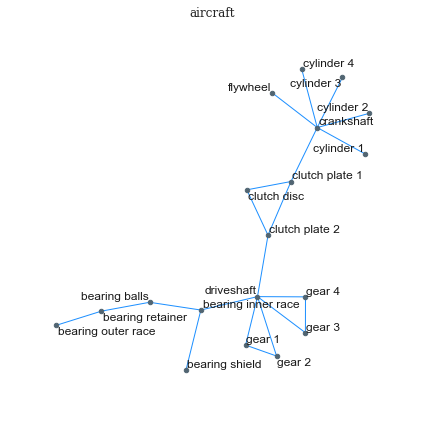

In [212]:


print(f'C_β = {nx.average_clustering(G):.2f}')

plt.figure(figsize=(6,6))
# draw_G(G, pos, withlabels=False, title=model+" (reduced)", node_size=20)
draw_G(G, pos, withlabels=True, title=model, node_size=20)
plt.tight_layout()
plt.margins(.15)

In [221]:
np.random.seed(8)
M = sample_censored(G, 20, 4, steps=100)



0 cylinder 4 → crankshaft → cylinder 2 → clutch plate 1
.
.
1 gear 3 → driveshaft → gear 1 → gear 2
.
.
2 driveshaft → bearing inner race → bearing shield → bearing balls
.
.
3 flywheel → crankshaft → cylinder 1 → clutch plate 1
.
.
19 crankshaft → cylinder 3 → flywheel → cylinder 4


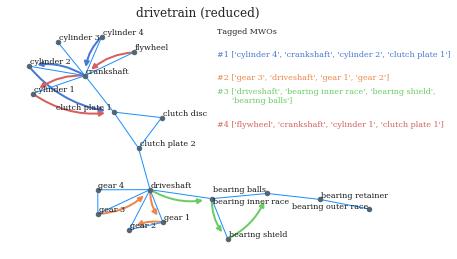

In [276]:

# from utils.plot_utils import figsize

flippos = {k:np.array([-1,1])*v for k,v in pos.items()}
# flippos = pos


# plt.savefig(latex_path/f'{model}_ivtRW.pdf')
#     plt.legend()

plot_ivt(G, flippos, M[:4], model, txtpos=.3 )

<IPython.core.display.Javascript object>


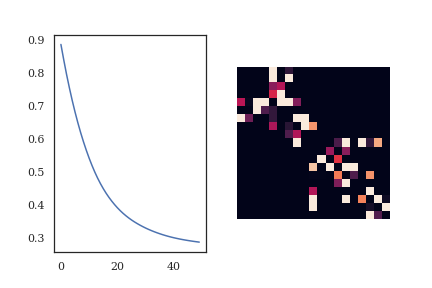

In [259]:
%matplotlib notebook

N = struct.shape[0]
approx = CensoredRW(N, sym=True)


learning_rate = 0.1

train(approx, np.array(M), compare_true=A,
      epochs=50, callback=True, lr=learning_rate)

%matplotlib inline

In [145]:


res = fill_diagonal(approx.P.detach().cpu().numpy(), 0)

prep = lambda A: labeled_adj(struct.columns, minmax(symmetrize(A)))

mkv1 = markov_model(M, k=1)
mkv2 = markov_model(M, k=2)
cos = cosine_model(M)

models = dict(
    INVITE = prep(res), 
    Cosine =  prep(cos), 
    MC1 =     prep(mkv1), 
    MC2 =     prep(mkv2),
)

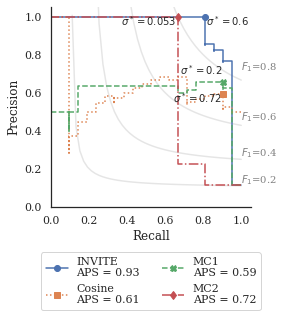

In [275]:

log = test_multi(A, **models)

compare_pvr(A, log)

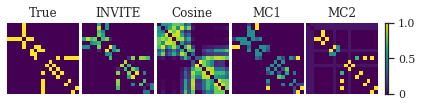

In [147]:
fig = plt.figure(figsize=figsize(columns=2))
compare_mats(
    A, 
#     labels=struct.columns,
    **models
)

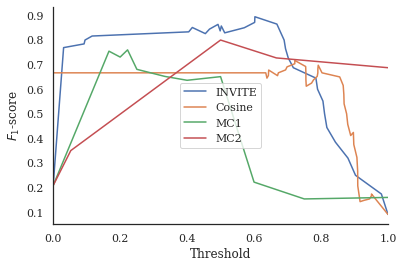

In [148]:
custom_cycler = (cycler(color=sns.color_palette(n_colors=4)) +
                 cycler(ls=['-', ':', '--', '-.']))

# f, ax = plt.subplots(fig)
for name, d in log.items():
    plt.plot(d['t'], d['f'], label=name)
    plt.legend(loc=0)
    plt.xlabel('Threshold')
    plt.ylabel('$F_1$-score')
    plt.xlim(0,1)
sns.despine()

this figure helps us qualitatively understand how the 3 different models are making errors in a locality

what can I generalize?

help the readers assess what kinds of problems

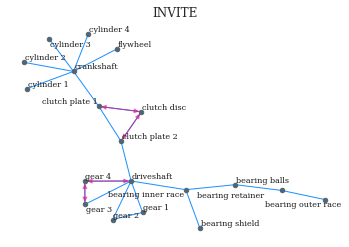

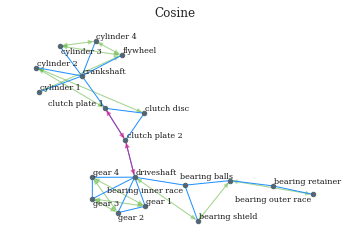

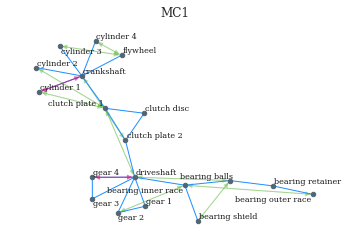

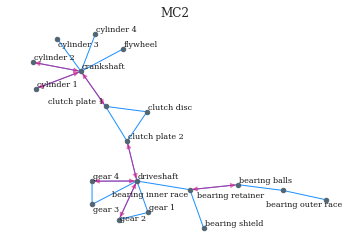

In [262]:
def thres_graph(G, pos, A_thres, name):
    A = nx.to_numpy_array(G)

    f = plt.figure(figsize=(6,4))
    in_approx     = nx.from_numpy_array(A_thres - A > 0, create_using=nx.DiGraph)
    not_in_approx = nx.from_numpy_array(A - A_thres > 0, create_using=nx.DiGraph)
#         print((d['thres'] - A > 0).sum(), (A - d['thres'] > 0).sum())
    draw_G(G, pos, fp=in_approx, fn=not_in_approx, 
           node_size=20, withlabels=True,
           font_size=pu.label_size(), font_family='serif',
           legend=False)
    plt.title(name)
    return f
for name, d in log.items():
    thres_graph(G, flippos, d['thres'], name)